# Manipulate images using DeepDream

The DeepDream algorithm is described in [this blog post](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)

The code in this notebook is mostly from [this tutorial](https://www.tensorflow.org/tutorials/generative/deepdream)


In [65]:
import tensorflow as tf

import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

# Chose image to use

Set `use_url = True` to use an image defined by an URL. Use together with `url`.

Set `use_url = False` to use an image from a local path. Use together with `local_image_path`.

<span style="color:blue">Make changes here to define which input image should be used</span>


In [66]:
# change this parameter to switch between url and local image 
use_url = True

# Mountains
url = 'https://images.unsplash.com/photo-1464822759023-fed622ff2c3b?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1650&q=80'

# Panda
# url = 'https://raw.githubusercontent.com/iris-hunkeler/ti8m-code-night-2021/main/test-images/panda.png'

# White Noise
# url = 'https://raw.githubusercontent.com/iris-hunkeler/ti8m-code-night-2021/main/test-images/white-noise.png'


# local_image_path = "/home/[user]/[image-path]"


Download/open image to use

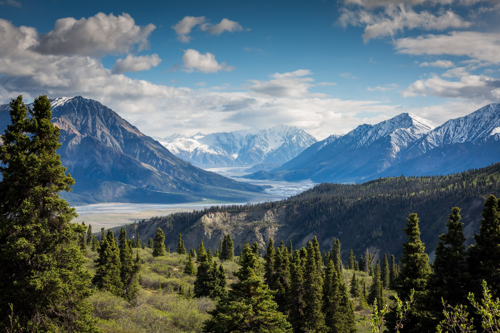

In [67]:
# Download an image and read it into a NumPy array.
def getImagePath(url):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  return image_path

# read image from path into NumPy array
def openOriginalImage(image_path, max_dim=None):
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)


# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

# Define image path: from url or locally
if use_url == True:
  image_path = getImagePath(url)
else:
  image_path = local_image_path

# Downsizing the image makes it easier to work with.
original_img = openOriginalImage(image_path, max_dim=500)
show(original_img)
display.display(display.HTML('original image'))

## Prepare pre-trained classification model

The pre-trained [InceptionV3](https://keras.io/api/applications/inceptionv3/) image classification model is used.

There is also a [Web Demo](https://transcranial.github.io/keras-js/#/inception-v3) availabe of it.


Download and prepare pre-trained image classification model

In [68]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

**Define which layers to enhance**
- lower layers -> result in more simple, geometric shapes
- deeper layers -> result in more sophisticated images (also require longer training)

InceptionV3 has 11 laysers: named 'mixed0' through 'mixed10'

<span style="color:blue">Make changes here to define which layers should be enhanced</span>

In [69]:
# Maximize the activations of these layers
names = ['mixed7', 'mixed9']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate loss for chosen layers

In [70]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## Gradient ascent

Calculate the gradients with respect to the image, and add them to the original image. This enhances the patterns seen by the network.

In [71]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [72]:
deepdream = DeepDream(dream_model)

## Version 1: Simple application

In [73]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  

  return result

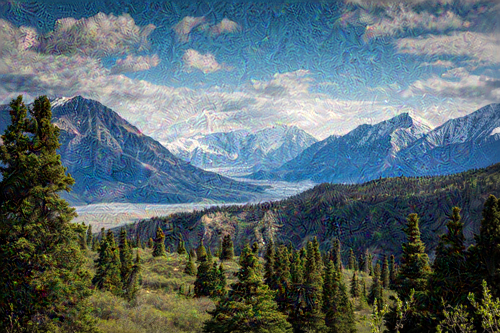

In [74]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)
show(dream_img)

## Version 2: apply gradient ascent at different scales 
(allows patterns generated at smaller scales to be incorporated into patterns at higher scales)

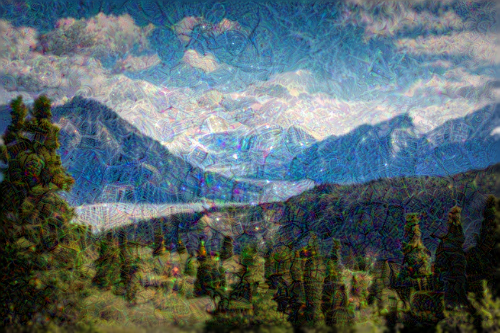

In [75]:
OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)

show(img)

## Version 3: Scaling up with tiles

In [76]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

shift, img_rolled = random_roll(np.array(original_img), 512)
# show(img_rolled)

In [77]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [78]:
get_tiled_gradients = TiledGradients(dream_model)

In [79]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

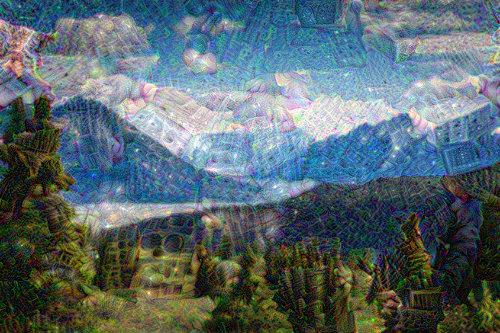

In [80]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)